In [1]:
import pandas as pd
import seaborn as sns
import librosa
from transformers import Wav2Vec2FeatureExtractor

In [39]:
ds = 'all'

(92783, 6)


,path,emotion,split,dataset,augmentation,language
0,../Datasets/custom_db/tess/train/angry_1068.wav,angry,train,tess,none,en
1,../Datasets/custom_db/tess/train/surprise_1286...,surprise,train,tess,none,en
2,../Datasets/custom_db/tess/train/fear_248.wav,fear,train,tess,none,en
3,../Datasets/custom_db/tess/train/happy_2790.wav,happy,train,tess,none,en
4,../Datasets/custom_db/tess/train/surprise_139.wav,surprise,train,tess,none,en
...,...,...,...,...,...,...
92778,../Datasets/custom_db/bser/augment/angry_254_f...,angry,augment,bser,freqmask,bn
92779,../Datasets/custom_db/bser/augment/sad_407_pit...,sad,augment,bser,pitchshift,bn
92780,../Datasets/custom_db/bser/augment/angry_1005_...,angry,augment,bser,pitchshift,bn
92781,../Datasets/custom_db/bser/augment/happy_309_f...,happy,augment,bser,freqmask,bn


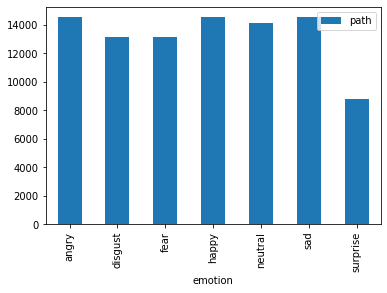

In [40]:
df = pd.read_csv('../Datasets/custom_db/df.csv')
# df = df[df['dataset'] == ds]
# df = df[df['language'] == 'bn']
df = df.rename(columns={'file': 'path'})
df['path'] = df['path'].apply(lambda path: '../Datasets/custom_db/' + path[2:])
# df = df[df['dataset'] == 'subesco']

df.groupby('emotion').count()[['path']].plot(kind='bar')
print(df.shape)
df

<AxesSubplot:xlabel='emotion'>

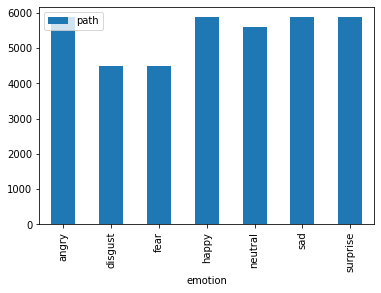

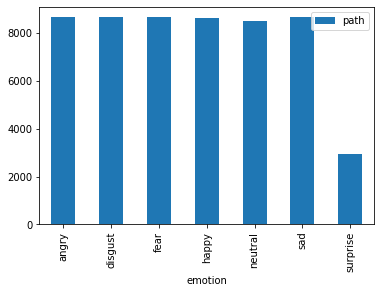

In [41]:
df1 = df[df['language'] == 'bn']
df2 = df[df['language'] == 'en']

df1.groupby('emotion').count()[['path']].plot(kind='bar')
df2.groupby('emotion').count()[['path']].plot(kind='bar')

def split_df(df: pd.DataFrame):
    train_df = df[df['split'] == 'train']
    train_aug_df = df[(df['split'] == 'train') | (df['split'] == 'augment')]
    val_df = df[df['split'] == 'val']
    test_df = df[df['split'] == 'test']

    return train_df, train_aug_df, val_df, test_df

def uniform_lang_distribution(df: pd.DataFrame) -> pd.DataFrame:
    df1 = df[df['language'] == 'bn']
    df2 = df[df['language'] == 'en']

    

In [ ]:
# sample_count = df[df['emotion'] != 'surprise'].groupby("emotion").count()[["path"]].min()[0] - df[df['emotion'] == 'surprise'].shape[0]
# sample_count
# df_sur = df[df['emotion'] == 'surprise'].sample(sample_count, replace=True)
# df2_new = pd.concat([df, df_sur])
# df2_new.groupby('emotion').count()[['path']].plot(kind='bar')
# df2_new.to_csv('../Datasets/custom_db/all_en_bal.csv', index=False)
# df = df2_new

In [ ]:
# df_test = pd.concat([df1, df2])
# df_test.groupby('emotion').count()[['path']].plot(kind='bar')
# df_test.groupby('emotion').count()[['path']]
# df_test.to_csv('../Datasets/custom_db/df_balanced.csv', index=False)

In [ ]:

# # train_df1 = df1[df1['split'] == 'train']
# train_df1 = df1[(df1['split'] == 'train') | (df1['split'] == 'augment')]
# val_df1 = df1[df1['split'] == 'val']
# test_df1 = df1[df1['split'] == 'test']

# print(train_df1.shape, val_df1.shape, test_df1.shape)

In [ ]:

# # train_df2 = df2[df2['split'] == 'train']
# train_df2 = df2[(df2['split'] == 'train') | (df2['split'] == 'augment')]
# val_df2 = df2[df2['split'] == 'val']
# test_df2 = df2[df2['split'] == 'test']

# print(train_df2.shape, val_df2.shape, test_df2.shape)


(51051, 6) (8512, 6) (1217, 6) (2433, 6)


<AxesSubplot:xlabel='emotion'>

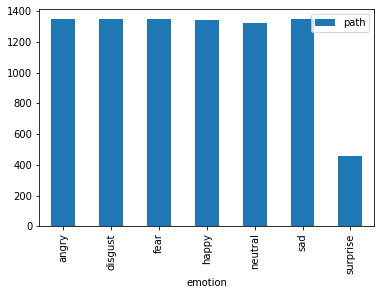

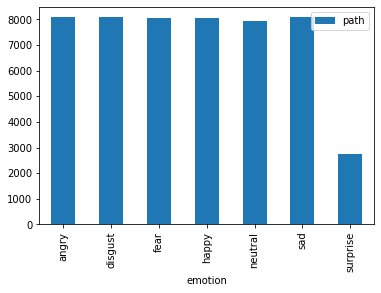

In [6]:
train_df = df[df['split'] == 'train']
train_aug_df = df[(df['split'] == 'train') | (df['split'] == 'augment')]
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

print(train_aug_df.shape, train_df.shape, val_df.shape, test_df.shape)
train_df.groupby('emotion').count()[['path']].plot(kind='bar')
train_aug_df.groupby('emotion').count()[['path']].plot(kind='bar')

In [16]:
def balance_df(df: pd.DataFrame) -> pd.DataFrame:
    sample_count = df[df['emotion'] != 'surprise'].groupby("emotion").count()[["path"]].min()[0] - df[df['emotion'] == 'surprise'].shape[0]
    print(sample_count)
    df_sur = df[df['emotion'] == 'surprise'].sample(sample_count, replace=True)
    df2_new = pd.concat([df, df_sur])
    # df2_new.groupby('emotion').count()[['path']].plot(kind='bar')
    # df2_new.to_csv('../Datasets/custom_db/all_en_bal.csv', index=False)
    return df2_new

869


<AxesSubplot:xlabel='emotion'>

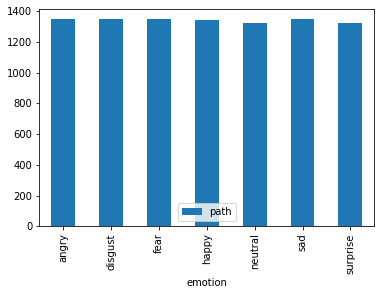

In [19]:
train_df = balance_df(train_df)
train_df.groupby('emotion').count()[['path']].plot(kind='bar')

5211


<AxesSubplot:xlabel='emotion'>

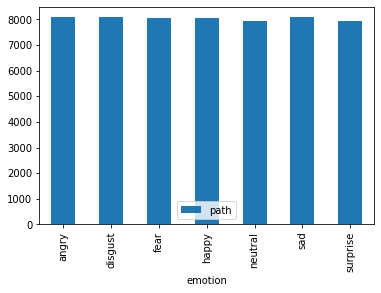

In [20]:
train_aug_df = balance_df(train_aug_df)
train_aug_df.groupby('emotion').count()[['path']].plot(kind='bar')

<AxesSubplot:xlabel='emotion'>

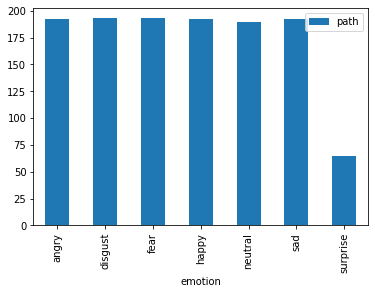

In [21]:
val_df.groupby('emotion').count()[['path']].plot(kind='bar')

<AxesSubplot:xlabel='emotion'>

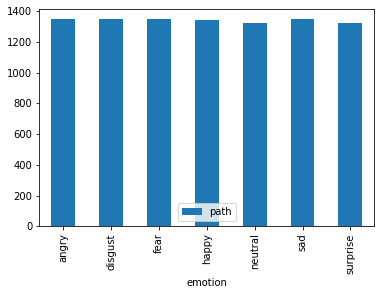

In [22]:

# train_df = pd.concat([train_df1, train_df2])
# # train_aug_df = pd.concat([train_aug_df1, train_aug_df2])
# val_df = pd.concat([val_df1, val_df2])
# test_df = pd.concat([test_df1, test_df2])

# print(train_df.shape, val_df.shape, test_df.shape)

# import matplotlib.pyplot as plt
# sns.countplot(x='language', data=train_df)
# plt.show()
# sns.countplot(x='language', data=val_df)
# plt.show()
# sns.countplot(x='language', data=test_df)
# plt.show()

train_df.groupby('emotion').count()[['path']].plot(kind='bar')

In [23]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

Labels:  ['angry' 'surprise' 'fear' 'happy' 'sad' 'neutral' 'disgust']



,path
emotion,
angry,8654
disgust,8652
fear,8649
happy,8646
neutral,8515
sad,8655
surprise,2930


In [24]:
save_path = "./"

# train_df = df[df['split'] == 'train']
# train_aug_df = df[(df['split'] == 'train') | (df['split'] == 'augment')]
# val_df = df[df['split'] == 'val']
# test_df = df[df['split'] == 'test']

train_df = train_df.reset_index(drop=True)
train_aug_df = train_aug_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
train_aug_df.to_csv(f"{save_path}/train_aug.csv", sep="\t", encoding="utf-8", index=False)
val_df.to_csv(f"{save_path}/val.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_aug_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(56262, 6)
(9381, 6)
(1217, 6)
(2433, 6)


## Prepare Data for Training

In [25]:
# Loading the created dataset using datasets
from datasets import load_dataset


data_files = {
    "train": f"{save_path}train.csv", 
    "validation": f"{save_path}val.csv", 
}

data_files_aug = {
    "train": f"{save_path}train_aug.csv", 
    "validation": f"{save_path}val.csv", 
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
dataset_aug = load_dataset("csv", data_files=data_files_aug, delimiter="\t", )
train_dataset = dataset["train"]
train_aug_dataset = dataset_aug["train"]
eval_dataset = dataset["validation"]

Using custom data configuration default-1b39d08934c7fb80


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/sam/.cache/huggingface/datasets/csv/default-1b39d08934c7fb80/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration default-ea28f7080a9ffddc


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/sam/.cache/huggingface/datasets/csv/default-ea28f7080a9ffddc/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

In [27]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 7 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Preprocess Data

In [28]:
model_name_or_path = "facebook/hubert-base-ls960"
# model_name_or_path = 'facebook/hubert-large-ls960-ft'
# model_name_or_path = "facebook/hubert-xlarge-ll60k" # Needs too much memory
# model_name_or_path = "facebook/hubert-large-ll60k" # Need to try again

pooling_mode = "mean"

In [29]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path,)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [30]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = librosa.load(path, sr=None)
    speech_array, _ = librosa.effects.trim(speech_array, top_db=25)

    if(sampling_rate != target_sampling_rate):
        raise ValueError(f"Sampling rate mismatch between file and target sampling rate. {sampling_rate} != {target_sampling_rate}")

    return speech_array

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = feature_extractor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [31]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

train_aug_dataset = train_aug_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

Parameter 'function'=<function preprocess_function at 0x7f297990e9e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


#0:   0%|          | 0/24 [00:00<?, ?ba/s]

#1:   0%|          | 0/24 [00:00<?, ?ba/s]

#2:   0%|          | 0/24 [00:00<?, ?ba/s]

#3:   0%|          | 0/24 [00:00<?, ?ba/s]

2022-12-21 11:56:48.505479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 11:56:48.624821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 11:56:49.576673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

#0:   0%|          | 0/141 [00:00<?, ?ba/s]

#1:   0%|          | 0/141 [00:00<?, ?ba/s]

#2:   0%|          | 0/141 [00:00<?, ?ba/s]

#3:   0%|          | 0/141 [00:00<?, ?ba/s]

2022-12-21 11:59:37.289049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 11:59:37.565417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 11:59:37.798368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#2:   0%|          | 0/4 [00:00<?, ?ba/s]

#3:   0%|          | 0/4 [00:00<?, ?ba/s]

2022-12-21 12:15:21.449332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 12:15:21.449332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 12:15:21.449329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [32]:
train_dataset.save_to_disk(f'../Datasets/hf_datasets/{ds}/base/train')
train_aug_dataset.save_to_disk(f'../Datasets/hf_datasets/{ds}/base/train_aug')
eval_dataset.save_to_disk(f'../Datasets/hf_datasets/{ds}/base/val')

In [33]:
test_dataset = load_dataset("csv", data_files={"test": "./test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-818f8517ce97cd74


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/sam/.cache/huggingface/datasets/csv/default-818f8517ce97cd74/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['path', 'emotion', 'split', 'dataset', 'augmentation', 'language'],
    num_rows: 2433
})

In [34]:
# model_name_or_path = "m3hrdadfi/hubert-base-greek-speech-emotion-recognition"
# config = AutoConfig.from_pretrained(model_name_or_path)
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
# model = HubertForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [35]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = librosa.load(batch["path"], sr=None)
    speech_array, _ = librosa.effects.trim(speech_array, top_db=25)
    if sampling_rate != target_sampling_rate:
        raise ValueError(f"Sampling rate mismatch between file and target sampling rate. {sampling_rate} != {target_sampling_rate}")
    batch["speech"] = speech_array
    return batch

In [36]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/2433 [00:00<?, ?ex/s]

In [37]:
test_dataset.save_to_disk(f'../Datasets/hf_datasets/{ds}/base/test')